In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

In [2]:
df = df_ = pd.read_csv(filepath_or_buffer="C:\\Lib\\fifa_players.csv")
df = df_.copy()

In [3]:
from sklearn.preprocessing import LabelEncoder
df = df.drop(columns=['full_name','name','birth_date','nationality'])

categorical_to_nums = {'preferred_foot'  :   {'Left'  : 0, 'Right' : 1,},
                       'body_type'  :   {'Lean'  : 0, 'Normal' : 1, 'Stocky' : 2}} 
for column, mapping in categorical_to_nums.items():
    temp_series = df[column].copy()
    null_mask = temp_series.isnull()
    temp_series.loc[~null_mask] = temp_series.loc[~null_mask].map(mapping) 
    df[column] = temp_series.fillna(-1).astype('int64')

df['positions'] = df['positions'].str.split(',').str[0]   


for column in ['height_cm','value_euro','wage_euro','release_clause_euro' ]:   
    df[column] = df.groupby('positions')[column].transform(lambda x: x.fillna(x.median()))
    
    
    
df = df.drop(columns=['national_team','national_team_position','national_jersey_number','national_rating'])


encoder = LabelEncoder()

df['positions_encoded'] = encoder.fit_transform(df['positions'])


df = df.drop(columns=['positions'])

C:\Users\redoe\AppData\Local\Temp\ipykernel_23100\3583185044.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = temp_series.fillna(-1).astype('int64')
C:\Users\redoe\AppData\Local\Temp\ipykernel_23100\3583185044.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = temp_series.fillna(-1).astype('int64')


In [4]:
X = df.drop(columns=['value_euro'])


y = df['value_euro']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1,test_size=0.20)

In [5]:
from sklearn.feature_selection import mutual_info_regression
mutual_info = mutual_info_regression(X,y)
mutual_info = pd.Series(mutual_info, index=X.columns)

In [6]:
from sklearn.feature_selection import SelectPercentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=20)
selected_top_columns.fit(X_train,y_train)

SelectPercentile(percentile=20,
                 score_func=<function mutual_info_regression at 0x000001DF6A650360>)

In [7]:
X_train = pd.DataFrame(selected_top_columns.transform(X_train), 
                     columns=X_train.columns[selected_top_columns.get_support()], 
                     index=X_train.index)

X_test = pd.DataFrame(selected_top_columns.transform(X_test), 
                    columns=X_test.columns[selected_top_columns.get_support()], 
                    index=X_test.index)

{'Mean Squared Error': 897232419576.0078, 'Root Mean Squared Error': 947223.5320007668, 'Mean Absolute Error': 421565.7912600682, 'Cross Validation': array([0.94369752, 0.9758484 , 0.96849267, 0.9654786 , 0.97824847,
       0.96945927, 0.96831741, 0.95369424, 0.96062641, 0.94988689]), 'R2 Score': 0.9722740179022966}


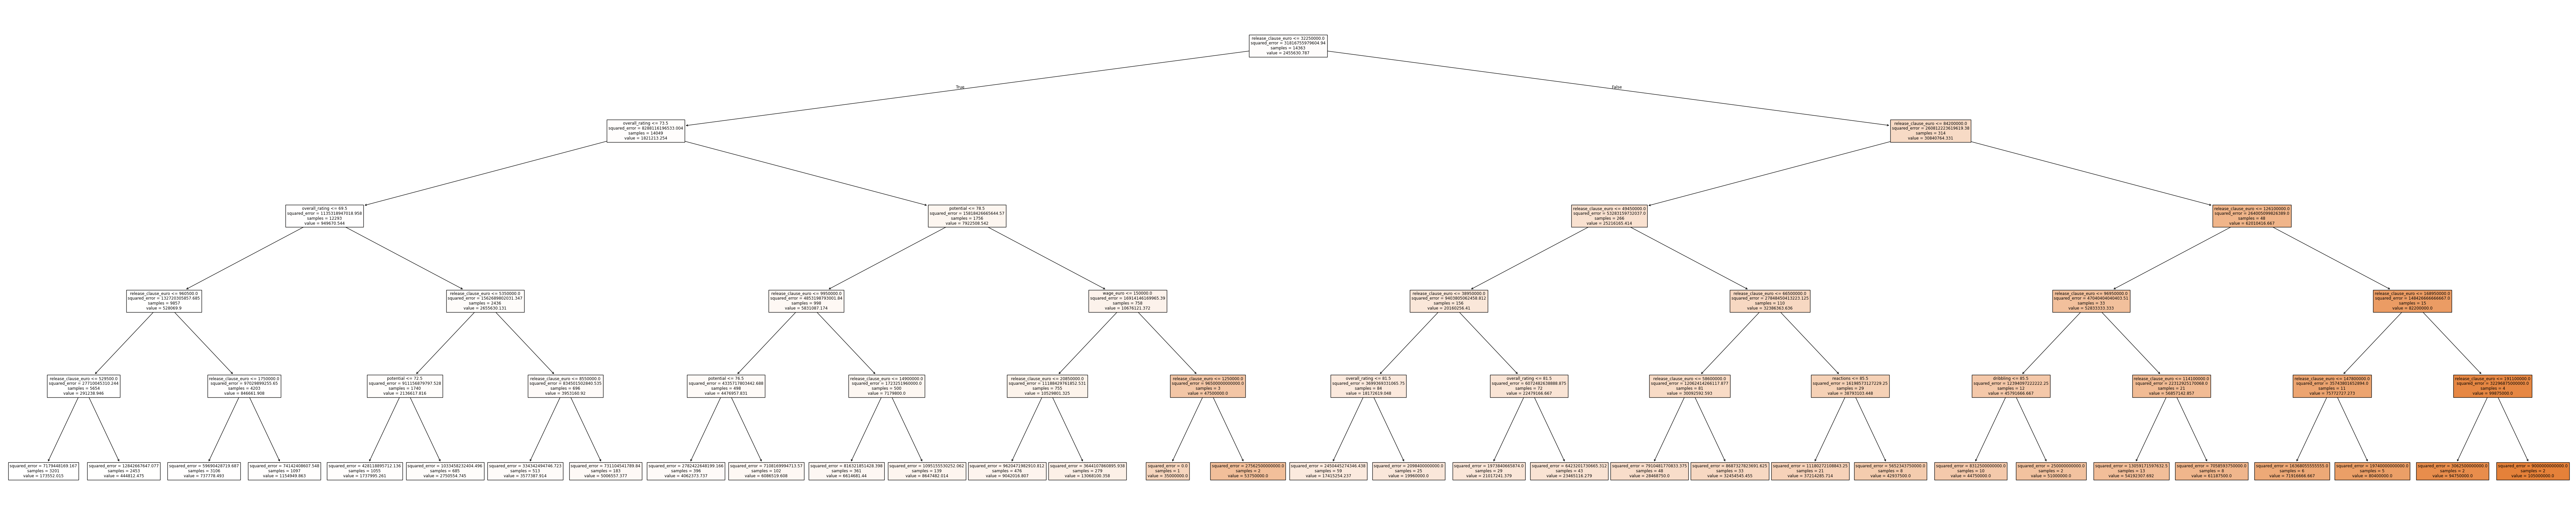

In [8]:
regressor = DecisionTreeRegressor(random_state=0, max_depth=5)
regressor.fit(X_train, y_train)
dtree_pred = regressor.predict(X_test)
    
dtree_pred_abs = abs(dtree_pred)
dtree_score_train = regressor.score(X_train, y_train)
dtree_score_test = regressor.score(X_test, y_test)



mse = mean_squared_error(y_test, dtree_pred)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, dtree_pred)
cross_val = cross_val_score(regressor, X_train, y_train, cv=10)
r2 = r2_score(y_test, dtree_pred)
dtree_values = {'Mean Squared Error'       :   mse,
                     'Root Mean Squared Error'  :   rmse,
                     'Mean Absolute Error'      :   mae,
                     'Cross Validation'         :   cross_val,
                     'R2 Score'                 :   r2}

fig = plt.figure(figsize=(100,20))
_ = tree.plot_tree(regressor, feature_names=X_train.columns,filled=True)
fig.savefig("decistion_tree.png")




print(dtree_values)
